In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

2024-11-10 13:07:34.290109: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-10 13:07:34.312738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731240454.321239  199042 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731240454.323768  199042 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 13:07:34.333034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Def various functions for labels transformation and common sense error

In [2]:
def periodic_trans(time):
    time_period = np.round([np.cos(time[:,0]/12*2*np.pi),
                            np.sin(time[:,0]/12*2*np.pi),
                            np.cos(time[:,1]/60*2*np.pi),
                            np.sin(time[:,1]/60*2*np.pi)],5)
    return time_period.T

def period_to_hrmin(period_time,hr_or_min):
    # convert period to clk time (either hr or min, for hr use 12, for min use 60 for hr_or_min)
    time_y_rad = np.arctan2(period_time[:,1],period_time[:,0])
    time_y = (time_y_rad < 0)*2*np.pi + time_y_rad
    time_clk = time_y/2/np.pi*hr_or_min
    return np.round(time_clk)

def period_to_clk(period_time):
    return np.array([period_to_hrmin(period_time[:,:2],12),
                     period_to_hrmin(period_time[:,2:],60)]).T

# ty1 = period_to_clk(train_ty_period)
# test_ty_period = periodic_trans(test_ty)

def calculate_angle(vec1, vec2):
    dot_product = np.sum(vec1 * vec2, axis=1)
    mag1 = np.linalg.norm(vec1, axis=1)
    mag2 = np.linalg.norm(vec2, axis=1)
    cos_theta = dot_product / (mag1 * mag2)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid domain errors
    return angle

def common_sense_err(test_y,pred_y):
    hr_angle = calculate_angle(test_y[:,:2],pred_y[:,:2])
    min_angle = calculate_angle(test_y[:,2:],pred_y[:,2:])
    hr_diff = hr_angle/2/np.pi*12
    min_diff = min_angle/2/np.pi*60
    return np.round(np.array([hr_diff,min_diff]).T)

def single_angle_trans(clk_time):
    time_rad = clk_time[:,0]/12*2*np.pi + clk_time[:,1]/60*np.pi/6
    time_per = np.array(np.round([np.cos(time_rad),
                                  np.sin(time_rad)],5)).T
    return time_per

def s_ang_to_clk(s_angle):
    y_rad = np.arctan2(s_angle[:,1],s_angle[:,0])
    y_rad2 = (y_rad < 0)*2*np.pi + y_rad
    y_clk = y_rad2/2/np.pi*12
    return np.array([y_clk.astype(int),np.round(y_clk%1*60)]).T

def common_sense_err2(test_y,pred_y):
    sa1 = single_angle_trans(pred_y)
    sa2 = single_angle_trans(test_y)
    sa_diff = calculate_angle(sa1,sa2)
    hr_diff = sa_diff//(np.pi/6)
    min_diff = np.round((sa_diff%(np.pi/6)*6*60/np.pi))
    return np.array([hr_diff,min_diff]).T

# train_ty_period = periodic_trans(train_ty)
# print(train_ty_period[:10])
# train_ty_period[:,2:]

# y1 = period_to_hrmin(train_ty_period[:,2:],60)
# tt1 = test_ty_period[:3]
# tt2 = train_ty_period[:3]
# train_ty[:10]
# calculate_angle(tt1[:,:2],tt2[:,:2])
# print(common_sense_err(tt1,tt2))

# tt3 = single_angle_trans(train_ty[:3])
# tt4 = single_angle_trans(test_ty[:3])
# sa1 = calculate_angle(tt3,tt4)

# common_sense_err2(train_ty[:3],test_ty[:3])

### 75 x 75 Data

#### Import Data

In [9]:
time_x = np.load('s_images.npy')
time_y = np.load('s_labels.npy')
train_tx, test_tx, train_ty, test_ty = train_test_split(time_x, time_y, test_size=0.1, random_state=42)
train_ty[:10],test_ty[:10]
train_ty_period = periodic_trans(train_ty)
test_ty_period = periodic_trans(test_ty)
train_ty_period[:,2:]


array([[-0.97815,  0.20791],
       [-0.91355, -0.40674],
       [ 0.97815, -0.20791],
       ...,
       [-0.86603, -0.5    ],
       [-0.91355, -0.40674],
       [-0.99452, -0.10453]])

#### Model Type 5.1: Multi-head with scaled regression

In [10]:
K.clear_session()


input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(1,name='min_y')(min_y)

model_time_MH1 = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH1.summary()
print(model_time_MH1)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH1.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH1 = model_time_MH1.fit(train_tx, {'hr_y': train_ty[:,0], 'min_y': train_ty[:,1]/59},
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping, reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 75, 75, 1) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 73, 73,    │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 73, 73,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 34, 34,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 877,997 (3.35 MB)

 Trainable params: 877,549 (3.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - hr_y_accuracy: 0.0912 - hr_y_loss: 2.5804 - loss: 9.2209 - min_y_loss: 0.3847 - min_y_mae: 0.4318 - val_hr_y_accuracy: 0.0852 - val_hr_y_loss: 2.6091 - val_loss: 7.8787 - val_min_y_loss: 0.2284 - val_min_y_mae: 0.3879 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - hr_y_accuracy: 0.1261 - hr_y_loss: 2.4290 - loss: 7.1668 - min_y_loss: 0.0949 - min_y_mae: 0.2538 - val_hr_y_accuracy: 0.1519 - val_hr_y_loss: 2.3304 - val_loss: 5.9515 - val_min_y_loss: 0.0739 - val_min_y_mae: 0.2236 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - hr_y_accuracy: 0.1672 - hr_y_loss: 2.2960 - loss: 5.6373 - min_y_loss: 0.0828 - min_y_mae: 0.2335 - val_hr_y_accuracy: 0.2235 - val_hr_y_loss: 2.1178 - val_loss: 4.6769 - val_min_y_loss: 0.0670 - val_min_y_mae: 0.2084 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - hr_y

57/57 - 0s - 7ms/step - hr_y_accuracy: 0.9589 - hr_y_loss: 0.1257 - loss: 0.3221 - min_y_loss: 0.0168 - min_y_mae: 0.0779


[0.32214468717575073,
 0.12572112679481506,
 0.016778940334916115,
 0.9588888883590698,
 0.07785536348819733]

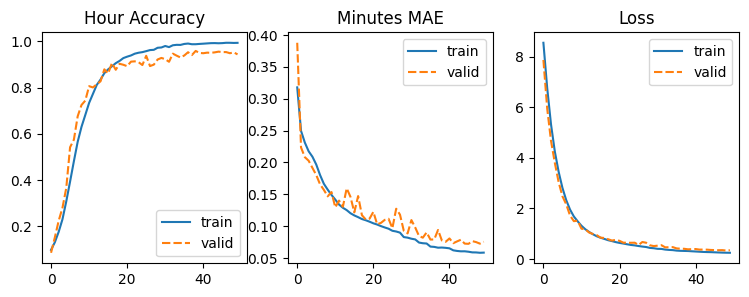

In [11]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH1.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH1.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH1.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH1.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH1.history['loss']
loss_df['valid'] = his_model_time_MH1.history['val_loss']
fig, axs = plt.subplots(ncols=3,figsize=(9,3))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
model_time_MH1.evaluate(test_tx,  {'hr_y': test_ty[:, 0], 'min_y': test_ty[:, 1] / 59}, verbose=2)

In [12]:
print(test_ty[0:10])
pred_hr_MH1,pred_min_MH1 = model_time_MH1.predict(test_tx)
hr_MH1 = np.argmax(tf.nn.softmax(pred_hr_MH1),axis=1)
min_MH1 = np.round(pred_min_MH1*60).flatten()
hr_MH1[:10],min_MH1[:10]
pred_MH1 = np.array([hr_MH1,min_MH1]).T
pred_MH1
np.mean(common_sense_err2(test_ty,pred_MH1),axis = 0)

[[ 1 42]
 [ 4 59]
 [ 6  8]
 [ 3 38]
 [ 0 29]
 [ 7 50]
 [ 0 34]
 [ 4 50]
 [ 7 39]
 [ 7 44]]
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


array([0.01222222, 5.41388889])

#### Multi-head with periodic transformation

In [13]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(2,name='min_y')(min_y)

model_time_MH2 = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH2.summary()
print(model_time_MH2)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH2.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH2 = model_time_MH2.fit(train_tx, {'hr_y': train_ty[:,0], 'min_y': train_ty_period[:,2:]},
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 75, 75, 1) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 73, 73,    │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 73, 73,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 34, 34,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 878,062 (3.35 MB)

 Trainable params: 877,614 (3.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - hr_y_accuracy: 0.0963 - hr_y_loss: 2.6143 - loss: 9.5647 - min_y_loss: 0.6737 - min_y_mae: 0.6858 - val_hr_y_accuracy: 0.0827 - val_hr_y_loss: 2.6190 - val_loss: 8.2887 - val_min_y_loss: 0.6163 - val_min_y_mae: 0.6722 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - hr_y_accuracy: 0.1281 - hr_y_loss: 2.4302 - loss: 7.4758 - min_y_loss: 0.3915 - min_y_mae: 0.5329 - val_hr_y_accuracy: 0.1728 - val_hr_y_loss: 2.2865 - val_loss: 6.1606 - val_min_y_loss: 0.2926 - val_min_y_mae: 0.4576 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - hr_y_accuracy: 0.1742 - hr_y_loss: 2.2568 - loss: 5.8762 - min_y_loss: 0.3234 - min_y_mae: 0.4751 - val_hr_y_accuracy: 0.2358 - val_hr_y_loss: 2.0287 - val_loss: 4.8433 - val_min_y_loss: 0.2480 - val_min_y_mae: 0.4148 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - hr

57/57 - 1s - 9ms/step - hr_y_accuracy: 0.9522 - hr_y_loss: 0.1390 - loss: 0.3463 - min_y_loss: 0.0215 - min_y_mae: 0.1094


[0.3463371694087982,
 0.13904500007629395,
 0.02154015377163887,
 0.9522222280502319,
 0.10941074788570404]

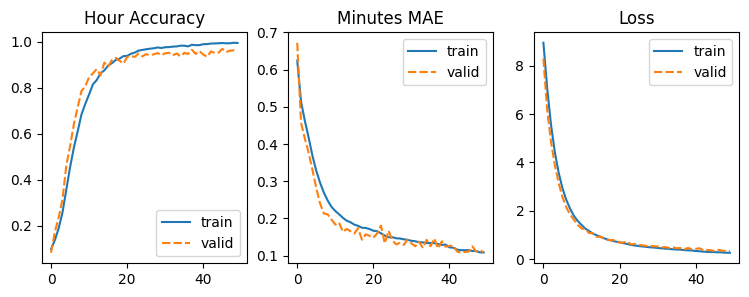

In [14]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH2.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH2.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH2.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH2.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH2.history['loss']
loss_df['valid'] = his_model_time_MH2.history['val_loss']
fig, axs = plt.subplots(ncols=3,figsize=(9,3))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
model_time_MH2.evaluate(test_tx,  {'hr_y': test_ty[:, 0], 'min_y':test_ty_period[:,2:] }, verbose=2)

In [15]:
# print(test_ty[0:10])
pred_hr_MH2,pred_min_MH2 = model_time_MH2.predict(test_tx)
pred_hr_MH2[:10],pred_min_MH2[:10]
hr_MH2 = np.argmax(tf.nn.softmax(pred_hr_MH2),axis=1)
min_MH2 = period_to_hrmin(pred_min_MH2,60)
hr_MH2[:10],min_MH2[:10]
pred_MH2 = np.array([hr_MH2,min_MH2]).T
print(test_ty[:3],pred_MH2[:3])
np.mean(common_sense_err2(test_ty,pred_MH2),axis = 0)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 43.]
 [ 5. 58.]
 [ 6.  8.]]


array([0.025     , 3.14111111])

#### Single Angle Periodic transformation

In [17]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_P1 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P1.summary()
print(model_time_P1)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P1.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P1 = model_time_P1.fit(train_tx, single_angle_trans(train_ty),
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,490 (1.78 MB)

 Trainable params: 467,042 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 3.7788 - mae: 0.6760 - val_loss: 3.0377 - val_mae: 0.6380 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.6730 - mae: 0.5238 - val_loss: 2.0192 - val_mae: 0.4499 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.8873 - mae: 0.4562 - val_loss: 1.4402 - val_mae: 0.4116 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.3452 - mae: 0.4071 - val_loss: 1.0138 - val_mae: 0.3401 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9589 - mae: 0.3494 - val_loss: 0.7413 - val_mae: 0.3079 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.6975 - mae: 0.3028 - val_loss: 0.5525 - val_mae: 0.2689 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5261 - mae: 0.2755 -

57/57 - 0s - 6ms/step - loss: 0.0178 - mae: 0.0652


[0.01777694746851921, 0.06524254381656647]

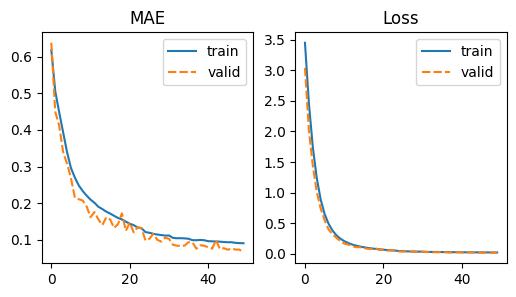

In [18]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P1.history['mae']
mae_df['valid'] = his_model_time_P1.history['val_mae']
loss_df['train'] = his_model_time_P1.history['loss']
loss_df['valid'] = his_model_time_P1.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P1.evaluate(test_tx,  single_angle_trans(test_ty), verbose=2)

In [19]:
# print(test_ty[0:10])
pred_y_P1 = model_time_P1.predict(test_tx)
pred_P1 = s_ang_to_clk(pred_y_P1)
print(test_ty[:3],pred_P1[:3])
np.mean(common_sense_err2(test_ty,pred_P1),axis = 0)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 17.]
 [ 5.  0.]
 [ 6.  0.]]


array([3.88888889e-03, 8.58055556e+00])

#### Double Angle Periodic transformation

In [20]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(4)(x)

model_time_P2 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P2.summary()
print(model_time_P2)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P2.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P2 = model_time_P2.fit(train_tx, train_ty_period,
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,620 (1.78 MB)

 Trainable params: 467,172 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 3.7891 - mae: 0.6972 - val_loss: 4.1942 - val_mae: 1.1485 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.4993 - mae: 0.5527 - val_loss: 1.8191 - val_mae: 0.4945 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.6934 - mae: 0.5068 - val_loss: 1.2495 - val_mae: 0.4650 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.1813 - mae: 0.4789 - val_loss: 0.8890 - val_mae: 0.4368 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.8585 - mae: 0.4615 - val_loss: 0.6690 - val_mae: 0.4277 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.6554 - mae: 0.4426 - val_loss: 0.5196 - val_mae: 0.4065 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5104 - mae: 0.4120 -

57/57 - 0s - 6ms/step - loss: 0.0309 - mae: 0.0939


[0.0308802779763937, 0.09389273077249527]

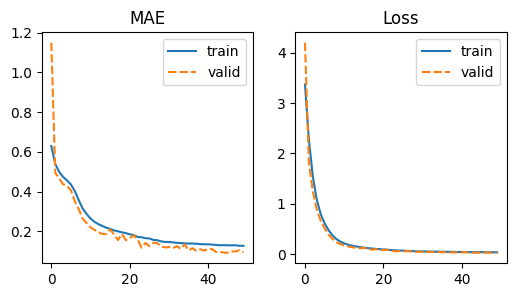

In [21]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P2.history['mae']
mae_df['valid'] = his_model_time_P2.history['val_mae']
loss_df['train'] = his_model_time_P2.history['loss']
loss_df['valid'] = his_model_time_P2.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P2.evaluate(test_tx,  test_ty_period, verbose=2)

In [22]:
# print(test_ty[0:10])
pred_y_P2 = model_time_P2.predict(test_tx)
pred_P2 = period_to_clk(pred_y_P2)
print(test_ty[:3],pred_P2[:3])
np.mean(common_sense_err2(test_ty,pred_P2),axis = 0)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 0. 42.]
 [ 4. 59.]
 [ 6.  8.]]


array([0.02388889, 3.47722222])

#### Dual Regression, scaled

In [23]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_DR1 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_DR1.summary()
print(model_time_DR1)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_DR1.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])
train_ty2 = np.array([train_ty[:,0]/11,train_ty[:,1]/59]).T
his_model_time_DR1 = model_time_DR1.fit(train_tx, train_ty2,
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,490 (1.78 MB)

 Trainable params: 467,042 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 3.3864 - mae: 0.3907 - val_loss: 2.5722 - val_mae: 0.4222 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.1660 - mae: 0.2636 - val_loss: 1.4906 - val_mae: 0.2295 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.3390 - mae: 0.2457 - val_loss: 0.9108 - val_mae: 0.2135 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.8229 - mae: 0.2298 - val_loss: 0.5690 - val_mae: 0.2108 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5206 - mae: 0.2249 - val_loss: 0.3675 - val_mae: 0.2103 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.3388 - mae: 0.2173 - val_loss: 0.2455 - val_mae: 0.2010 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2314 - mae: 0.2106 -

57/57 - 0s - 5ms/step - loss: 0.0204 - mae: 0.0754


[0.0203649140894413, 0.07541405409574509]

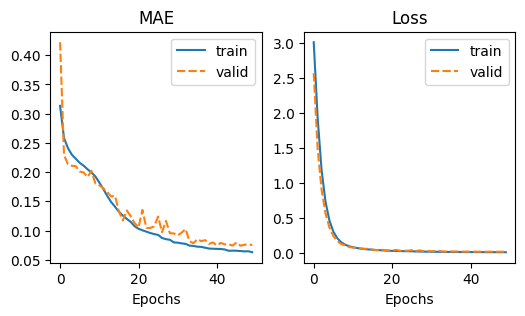

In [24]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_DR1.history['mae']
mae_df['valid'] = his_model_time_DR1.history['val_mae']
loss_df['train'] = his_model_time_DR1.history['loss']
loss_df['valid'] = his_model_time_DR1.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set(title = "MAE",xlabel='Epochs')
sns.lineplot(loss_df,ax=axs[1]).set(title = "Loss",xlabel='Epochs')
test_ty2 = np.array([test_ty[:,0]/11,test_ty[:,1]/59]).T
model_time_DR1.evaluate(test_tx,  test_ty2, verbose=2)

In [25]:
# print(test_ty[0:10])
pred_y_DR1 = model_time_DR1.predict(test_tx)
pred_DR1 = np.round(np.array([pred_y_DR1[:,0]*11,pred_y_DR1[:,1]*59]).T)
# pred_DR1 = np.round(pred_y_DR1)
print(test_ty[:3],pred_DR1[:3])
np.mean(common_sense_err2(test_ty,pred_DR1),axis = 0)
#array([ 1.41444444, 27.49444444])

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 5. 40.]
 [ 4. 35.]
 [ 7. 13.]]


array([ 0.41333333, 21.34166667])

#### Non scaled Dual regression

In [26]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_DR2 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_DR2.summary()
print(model_time_DR2)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_DR2.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])
his_model_time_DR2 = model_time_DR2.fit(train_tx, train_ty,
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,490 (1.78 MB)

 Trainable params: 467,042 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 227.8216 - mae: 10.5595 - val_loss: 632.6820 - val_mae: 18.8833 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 141.8069 - mae: 8.2030 - val_loss: 118.8531 - val_mae: 7.1101 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 120.2828 - mae: 7.3822 - val_loss: 238.0094 - val_mae: 10.4554 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 110.6961 - mae: 7.0199 - val_loss: 112.6621 - val_mae: 6.9294 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 100.1258 - mae: 6.6633 - val_loss: 135.1871 - val_mae: 7.6472 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 94.5242 - mae: 6.4127 - val_loss: 89.3504 - val_mae: 6.0305 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - los

57/57 - 0s - 5ms/step - loss: 59.5247 - mae: 4.5354


[59.52470397949219, 4.535434246063232]

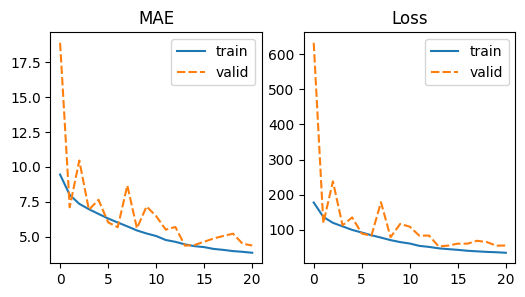

In [27]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_DR2.history['mae']
mae_df['valid'] = his_model_time_DR2.history['val_mae']
loss_df['train'] = his_model_time_DR2.history['loss']
loss_df['valid'] = his_model_time_DR2.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_DR2.evaluate(test_tx,  test_ty, verbose=2)

In [28]:
# print(test_ty[0:10])
pred_y_DR2 = model_time_DR2.predict(test_tx)
pred_DR2 = np.round(np.array([pred_y_DR2[:,0],pred_y_DR2[:,1]]).T)
# pred_DR1 = np.round(pred_y_DR1)
print(test_ty[:3],pred_DR2[:3])
np.mean(common_sense_err2(test_ty,pred_DR2),axis = 0)
#array([ 1.41444444, 27.49444444])

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 5. 42.]
 [ 8. 27.]
 [ 5. 27.]]


array([ 1.51722222, 29.18111111])

### 150 x 150

#### Import Data

In [3]:
time_x_L = np.load('images.npy')
time_y_L = np.load('labels.npy')
train_tx_L, test_tx_L, train_ty_L, test_ty_L = train_test_split(time_x_L, time_y_L, test_size=0.1, random_state=42)
train_ty_period_L = periodic_trans(train_ty_L)
test_ty_period_L = periodic_trans(test_ty_L)

#### Multi head scaled 

In [4]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(1,name='min_y')(min_y)

model_time_MH1_L = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH1_L.summary()
print(model_time_MH1_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH1_L.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH1_L = model_time_MH1_L.fit(train_tx_L, {'hr_y': train_ty_L[:,0], 'min_y': train_ty_L[:,1]/59},
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping, reduce_lr])

I0000 00:00:1731240469.836492  199042 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6166 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 148, 148,  │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 148, 148,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 34, 34,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 17, 17,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 18496)     │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  2,367,616 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  2,367,616 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]   

 Total params: 4,810,157 (18.35 MB)

 Trainable params: 4,809,709 (18.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50


I0000 00:00:1731240471.611633  199200 service.cc:148] XLA service 0x797b84018720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731240471.611657  199200 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-10 13:07:51.683626: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731240471.839616  199200 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-10 13:07:51.974589: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-11-10 13:07:5

  1/456 ━━━━━━━━━━━━━━━━━━━━ 46:44 6s/step - hr_y_accuracy: 0.0625 - hr_y_loss: 5.2631 - loss: 14.7089 - min_y_loss: 2.8030 - min_y_mae: 1.3805

I0000 00:00:1731240476.512520  199200 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


455/456 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - hr_y_accuracy: 0.0844 - hr_y_loss: 2.6343 - loss: 9.2863 - min_y_loss: 0.3354 - min_y_mae: 0.4088

2024-11-10 13:08:12.201309: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 40 bytes spill stores, 40 bytes spill loads

2024-11-10 13:08:12.208984: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 28 bytes spill stores, 28 bytes spill loads

2024-11-10 13:08:12.283216: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 56 bytes spill stores, 56 bytes spill loads

2024-11-10 13:08:12.385847: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 60 bytes spill stores, 60 bytes spill loads

2024-11-10 13:08:12.393689: I external/local_xla/xla/stream_executor/cud

456/456 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - hr_y_accuracy: 0.0844 - hr_y_loss: 2.6341 - loss: 9.2841 - min_y_loss: 0.3350 - min_y_mae: 0.4086 - val_hr_y_accuracy: 0.0827 - val_hr_y_loss: 2.5894 - val_loss: 8.1515 - val_min_y_loss: 1.0411 - val_min_y_mae: 0.9380 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - hr_y_accuracy: 0.1077 - hr_y_loss: 2.4720 - loss: 6.5930 - min_y_loss: 0.1089 - min_y_mae: 0.2705 - val_hr_y_accuracy: 0.1191 - val_hr_y_loss: 2.4427 - val_loss: 5.2294 - val_min_y_loss: 0.0752 - val_min_y_mae: 0.2205 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - hr_y_accuracy: 0.1297 - hr_y_loss: 2.4248 - loss: 4.9133 - min_y_loss: 0.0884 - min_y_mae: 0.2388 - val_hr_y_accuracy: 0.1210 - val_hr_y_loss: 2.4136 - val_loss: 4.1184 - val_min_y_loss: 0.0688 - val_min_y_mae: 0.2037 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - hr_y_accuracy: 0.1442 - hr_y_loss: 2.3842 - loss:

2024-11-10 13:20:57.130981: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 248 bytes spill stores, 272 bytes spill loads



57/57 - 1s - 22ms/step - hr_y_accuracy: 0.7978 - hr_y_loss: 0.5469 - loss: 0.7852 - min_y_loss: 0.0294 - min_y_mae: 0.1071
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


array([ 0.11111111, 11.10944444])

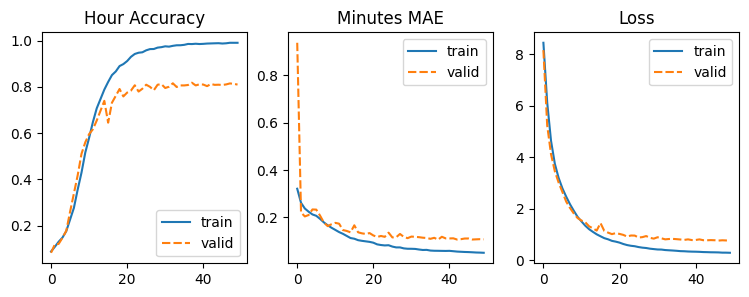

In [5]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH1_L.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH1_L.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH1_L.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH1_L.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH1_L.history['loss']
loss_df['valid'] = his_model_time_MH1_L.history['val_loss']
fig, axs = plt.subplots(ncols=3,figsize=(9,3))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
model_time_MH1_L.evaluate(test_tx_L,  {'hr_y': test_ty_L[:, 0], 'min_y': test_ty_L[:, 1] / 59}, verbose=2)
pred_hr_MH1_L,pred_min_MH1_L = model_time_MH1_L.predict(test_tx_L)
hr_MH1_L = np.argmax(tf.nn.softmax(pred_hr_MH1_L),axis=1)
min_MH1_L = np.round(pred_min_MH1_L*60).flatten()
hr_MH1_L[:10],min_MH1_L[:10]
pred_MH1_L = np.array([hr_MH1_L,min_MH1_L]).T
np.mean(common_sense_err2(test_ty_L,pred_MH1_L),axis = 0)

#### Multi head periodic

In [6]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(2,name='min_y')(min_y)

model_time_MH2_L = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH2_L.summary()
print(model_time_MH2_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH2_L.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH2_L = model_time_MH2_L.fit(train_tx_L, {'hr_y': train_ty_L[:,0], 'min_y': train_ty_period_L[:,2:]},
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 148, 148,  │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 148, 148,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 34, 34,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 17, 17,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 18496)     │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  2,367,616 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  2,367,616 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]   

 Total params: 4,810,222 (18.35 MB)

 Trainable params: 4,809,774 (18.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - hr_y_accuracy: 0.0835 - hr_y_loss: 2.6036 - loss: 9.7281 - min_y_loss: 0.8121 - min_y_mae: 0.7111 - val_hr_y_accuracy: 0.0864 - val_hr_y_loss: 2.5328 - val_loss: 7.9315 - val_min_y_loss: 0.6859 - val_min_y_mae: 0.6951 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - hr_y_accuracy: 0.1092 - hr_y_loss: 2.4414 - loss: 7.0905 - min_y_loss: 0.3943 - min_y_mae: 0.5330 - val_hr_y_accuracy: 0.1216 - val_hr_y_loss: 2.3928 - val_loss: 5.7565 - val_min_y_loss: 0.3018 - val_min_y_mae: 0.4655 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - hr_y_accuracy: 0.1325 - hr_y_loss: 2.3731 - loss: 5.4710 - min_y_loss: 0.3264 - min_y_mae: 0.4763 - val_hr_y_accuracy: 0.1586 - val_hr_y_loss: 2.2937 - val_loss: 4.6323 - val_min_y_loss: 0.2786 - val_min_y_mae: 0.4387 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step

57/57 - 1s - 13ms/step - hr_y_accuracy: 0.8206 - hr_y_loss: 0.5057 - loss: 0.7689 - min_y_loss: 0.0405 - min_y_mae: 0.1492
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 43.]
 [ 5. 59.]
 [ 6.  7.]]


array([0.125     , 8.18444444])

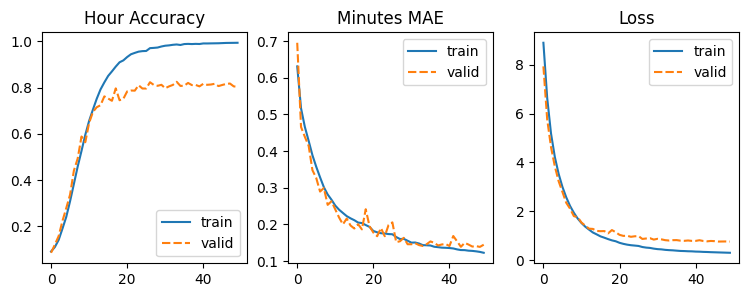

In [7]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH2_L.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH2_L.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH2_L.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH2_L.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH2_L.history['loss']
loss_df['valid'] = his_model_time_MH2_L.history['val_loss']
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(9,3))
# plt.figure(figsize=(6,15))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
# axs[1, 1].axis('off')
model_time_MH2_L.evaluate(test_tx_L,  {'hr_y': test_ty_L[:, 0], 'min_y':test_ty_period_L[:,2:] }, verbose=2)
# print(test_ty[0:10])
pred_hr_MH2_L,pred_min_MH2_L = model_time_MH2_L.predict(test_tx_L)
pred_hr_MH2_L[:10],pred_min_MH2_L[:10]
hr_MH2_L = np.argmax(tf.nn.softmax(pred_hr_MH2_L),axis=1)
min_MH2_L = period_to_hrmin(pred_min_MH2_L,60)
hr_MH2_L[:10],min_MH2_L[:10]
pred_MH2_L = np.array([hr_MH2_L,min_MH2_L]).T
print(test_ty_L[:3],pred_MH2_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_MH2_L),axis = 0)

#### Single Angle Periodic

In [8]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_P1_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P1_L.summary()
print(model_time_P1_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P1_L.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P1_L = model_time_P1_L.fit(train_tx_L, single_angle_trans(train_ty_L),
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433,570 (9.28 MB)

 Trainable params: 2,433,122 (9.28 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 3.9147 - mae: 0.6894 - val_loss: 3.0963 - val_mae: 0.6615 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 2.6067 - mae: 0.5110 - val_loss: 1.9012 - val_mae: 0.4556 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 1.7508 - mae: 0.4457 - val_loss: 1.2675 - val_mae: 0.3919 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 1.1691 - mae: 0.3833 - val_loss: 0.8506 - val_mae: 0.3219 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.8139 - mae: 0.3451 - val_loss: 0.5984 - val_mae: 0.2931 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.5792 - mae: 0.3141 - val_loss: 0.4329 - val_mae: 0.2610 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.4377 - 

57/57 - 1s - 9ms/step - loss: 0.0490 - mae: 0.1253
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 26.]
 [ 4. 59.]
 [ 5. 20.]]


array([1.16666667e-02, 1.30255556e+01])

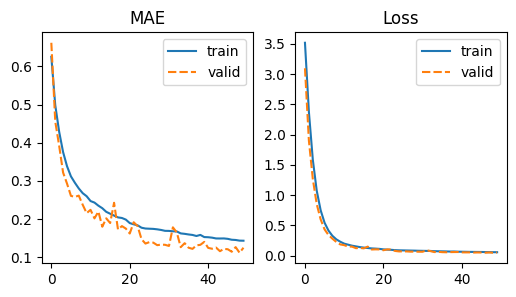

In [9]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P1_L.history['mae']
mae_df['valid'] = his_model_time_P1_L.history['val_mae']
loss_df['train'] = his_model_time_P1_L.history['loss']
loss_df['valid'] = his_model_time_P1_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P1_L.evaluate(test_tx_L,  single_angle_trans(test_ty_L), verbose=2)
# print(test_ty[0:10])
pred_y_P1_L = model_time_P1_L.predict(test_tx_L)
pred_P1_L = s_ang_to_clk(pred_y_P1_L)
print(test_ty_L[:3],pred_P1_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_P1_L),axis = 0)

#### Double angle periodic

In [10]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(4)(x)

model_time_P2_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P2_L.summary()
print(model_time_P2_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P2_L.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P2_L = model_time_P2_L.fit(train_tx_L, train_ty_period_L,
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433,700 (9.28 MB)

 Trainable params: 2,433,252 (9.28 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 3.9865 - mae: 0.7106 - val_loss: 3.1195 - val_mae: 0.6859 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 2.6329 - mae: 0.5494 - val_loss: 1.9242 - val_mae: 0.4987 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 1.7811 - mae: 0.5049 - val_loss: 1.3195 - val_mae: 0.4760 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 1.2356 - mae: 0.4849 - val_loss: 0.9302 - val_mae: 0.4527 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.8948 - mae: 0.4704 - val_loss: 0.7066 - val_mae: 0.4545 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.6817 - mae: 0.4584 - val_loss: 0.5464 - val_mae: 0.4320 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.5424 - 

57/57 - 1s - 10ms/step - loss: 0.0513 - mae: 0.1203
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 45.]
 [ 5. 58.]
 [ 6. 10.]]


array([0.035     , 6.29111111])

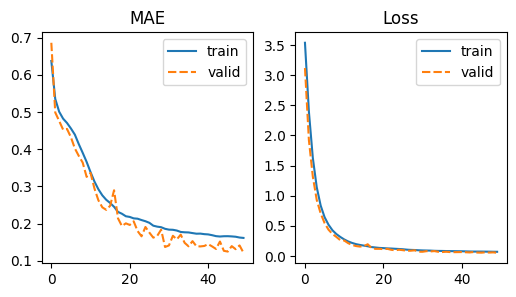

In [11]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P2_L.history['mae']
mae_df['valid'] = his_model_time_P2_L.history['val_mae']
loss_df['train'] = his_model_time_P2_L.history['loss']
loss_df['valid'] = his_model_time_P2_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P2_L.evaluate(test_tx_L,  test_ty_period_L, verbose=2)
# print(test_ty[0:10])
pred_y_P2_L = model_time_P2_L.predict(test_tx_L)
pred_P2_L = period_to_clk(pred_y_P2_L)
print(test_ty_L[:3],pred_P2_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_P2_L),axis = 0)

In [12]:
# print(np.mean(common_sense_err2(test_ty_L[10:20],pred_P2_L[10:20]),axis = 0))
# test_ty_L[10:20],pred_P2_L[10:20]

#### Double Regression scaled

In [13]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_DR1_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_DR1_L.summary()
print(model_time_DR1_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_DR1_L.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])
train_ty2_L = np.array([train_ty_L[:,0]/11,train_ty_L[:,1]/59]).T
his_model_time_DR1_L = model_time_DR1_L.fit(train_tx_L, train_ty2_L,
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433,570 (9.28 MB)

 Trainable params: 2,433,122 (9.28 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 3.5505 - mae: 0.4240 - val_loss: 3.5684 - val_mae: 0.9026 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 2.2177 - mae: 0.2722 - val_loss: 1.5312 - val_mae: 0.2370 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 1.3797 - mae: 0.2529 - val_loss: 0.9466 - val_mae: 0.2314 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.8562 - mae: 0.2460 - val_loss: 0.5947 - val_mae: 0.2311 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.5407 - mae: 0.2375 - val_loss: 0.3816 - val_mae: 0.2208 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.3536 - mae: 0.2331 - val_loss: 0.2573 - val_mae: 0.2191 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.2438 - 

57/57 - 0s - 8ms/step - loss: 0.0500 - mae: 0.1498
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


array([ 1.05833333, 29.665     ])

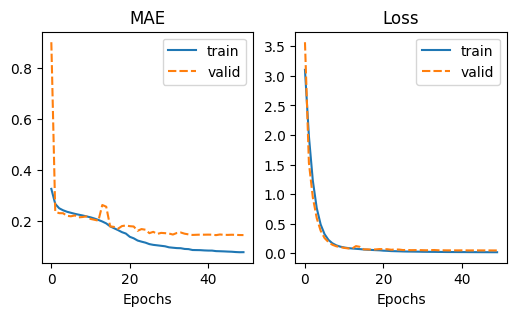

In [14]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_DR1_L.history['mae']
mae_df['valid'] = his_model_time_DR1_L.history['val_mae']
loss_df['train'] = his_model_time_DR1_L.history['loss']
loss_df['valid'] = his_model_time_DR1_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set(title = "MAE",xlabel='Epochs')
sns.lineplot(loss_df,ax=axs[1]).set(title = "Loss",xlabel='Epochs')
test_ty2_L = np.array([test_ty_L[:,0]/11,test_ty_L[:,1]/59]).T
model_time_DR1_L.evaluate(test_tx_L,  test_ty2_L, verbose=2)
pred_y_DR1_L = model_time_DR1_L.predict(test_tx_L)
pred_DR1_L = np.round(np.array([pred_y_DR1_L[:,0]*11,pred_y_DR1_L[:,1]*59]).T)
np.mean(common_sense_err2(test_ty_L,pred_DR1_L),axis = 0)

#### Additional Layers

##### MH2 with additional conv layer

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 148, 148,  │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 148, 148,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 34, 34,    │      9,248 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]   

 Total params: 887,438 (3.39 MB)

 Trainable params: 886,926 (3.38 MB)

 Non-trainable params: 512 (2.00 KB)

<Functional name=functional, built=True>
Epoch 1/50


2024-11-10 14:11:45.763561: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 540 bytes spill stores, 604 bytes spill loads

2024-11-10 14:11:45.786122: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 40 bytes spill stores, 40 bytes spill loads

2024-11-10 14:11:45.789330: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 28 bytes spill stores, 28 bytes spill loads

2024-11-10 14:11:45.802885: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 56 bytes spill stores, 56 bytes spill loads

2024-11-10 14:11:45.837175: I external/local_xla/xla/stream_executor/cuda/

452/456 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - hr_y_accuracy: 0.0868 - hr_y_loss: 2.6357 - loss: 9.7256 - min_y_loss: 0.7578 - min_y_mae: 0.7132

2024-11-10 14:12:03.242669: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 16 bytes spill stores, 16 bytes spill loads

2024-11-10 14:12:03.268677: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 28 bytes spill stores, 28 bytes spill loads

2024-11-10 14:12:03.306223: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 40 bytes spill stores, 40 bytes spill loads

2024-11-10 14:12:03.344814: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 60 bytes spill stores, 60 bytes spill loads

2024-11-10 14:12:03.347026: I external/local_xla/xla/stream_executor/cuda/cu

456/456 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - hr_y_accuracy: 0.0868 - hr_y_loss: 2.6353 - loss: 9.7228 - min_y_loss: 0.7570 - min_y_mae: 0.7128 - val_hr_y_accuracy: 0.0901 - val_hr_y_loss: 2.6689 - val_loss: 8.7685 - val_min_y_loss: 0.8494 - val_min_y_mae: 0.7559 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - hr_y_accuracy: 0.1395 - hr_y_loss: 2.4001 - loss: 7.6885 - min_y_loss: 0.4152 - min_y_mae: 0.5533 - val_hr_y_accuracy: 0.1833 - val_hr_y_loss: 2.2034 - val_loss: 6.3568 - val_min_y_loss: 0.3041 - val_min_y_mae: 0.4690 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - hr_y_accuracy: 0.2061 - hr_y_loss: 2.1628 - loss: 6.0569 - min_y_loss: 0.3291 - min_y_mae: 0.4791 - val_hr_y_accuracy: 0.2593 - val_hr_y_loss: 1.9198 - val_loss: 5.0118 - val_min_y_loss: 0.2704 - val_min_y_mae: 0.4370 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - hr_y_accuracy: 0.2792 - hr_y_loss: 1.9059 - loss:

2024-11-10 14:24:24.983568: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 248 bytes spill stores, 272 bytes spill loads



57/57 - 1s - 19ms/step - hr_y_accuracy: 0.9717 - hr_y_loss: 0.1002 - loss: 0.2933 - min_y_loss: 0.0170 - min_y_mae: 0.0944
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 44.]
 [ 5. 60.]
 [ 6.  7.]]


array([0.01      , 2.60555556])

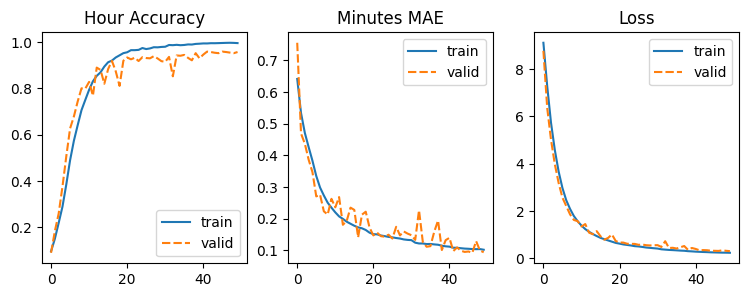

In [15]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(2,name='min_y')(min_y)

model_time_MH2_L = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH2_L.summary()
print(model_time_MH2_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH2_L.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH2_L = model_time_MH2_L.fit(train_tx_L, {'hr_y': train_ty_L[:,0], 'min_y': train_ty_period_L[:,2:]},
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH2_L.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH2_L.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH2_L.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH2_L.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH2_L.history['loss']
loss_df['valid'] = his_model_time_MH2_L.history['val_loss']
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(9,3))
# plt.figure(figsize=(6,15))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
# axs[1, 1].axis('off')
model_time_MH2_L.evaluate(test_tx_L,  {'hr_y': test_ty_L[:, 0], 'min_y':test_ty_period_L[:,2:] }, verbose=2)
pred_hr_MH2_L,pred_min_MH2_L = model_time_MH2_L.predict(test_tx_L)
pred_hr_MH2_L[:10],pred_min_MH2_L[:10]
hr_MH2_L = np.argmax(tf.nn.softmax(pred_hr_MH2_L),axis=1)
min_MH2_L = period_to_hrmin(pred_min_MH2_L,60)
hr_MH2_L[:10],min_MH2_L[:10]
pred_MH2_L = np.array([hr_MH2_L,min_MH2_L]).T
print(test_ty_L[:3],pred_MH2_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_MH2_L),axis = 0)

##### Single Angle

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476,866 (1.82 MB)

 Trainable params: 476,354 (1.82 MB)

 Non-trainable params: 512 (2.00 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 3.9632 - mae: 0.7215 - val_loss: 3.2377 - val_mae: 0.6516 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 2.8839 - mae: 0.5199 - val_loss: 2.2868 - val_mae: 0.4566 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 2.1540 - mae: 0.4622 - val_loss: 1.6699 - val_mae: 0.4024 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 1.5766 - mae: 0.4142 - val_loss: 1.2132 - val_mae: 0.3655 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 1.1415 - mae: 0.3649 - val_loss: 0.8783 - val_mae: 0.3219 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.8260 - mae: 0.3168 - val_loss: 0.6312 - val_mae: 0.2621 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.6047 - 

array([2.77777778e-03, 9.11000000e+00])

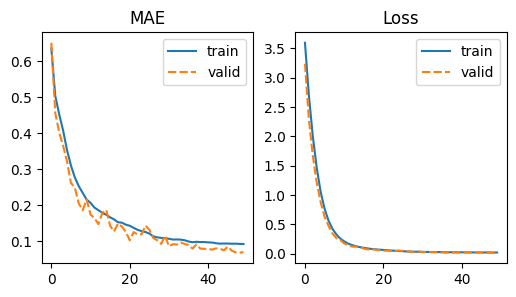

In [16]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_P1_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P1_L.summary()
print(model_time_P1_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P1_L.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P1_L = model_time_P1_L.fit(train_tx_L, single_angle_trans(train_ty_L),
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P1_L.history['mae']
mae_df['valid'] = his_model_time_P1_L.history['val_mae']
loss_df['train'] = his_model_time_P1_L.history['loss']
loss_df['valid'] = his_model_time_P1_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P1_L.evaluate(test_tx_L,  single_angle_trans(test_ty_L), verbose=2)
pred_y_P1_L = model_time_P1_L.predict(test_tx_L)
pred_P1_L = s_ang_to_clk(pred_y_P1_L)
np.mean(common_sense_err2(test_ty_L,pred_P1_L),axis = 0)

##### Double Angle

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476,996 (1.82 MB)

 Trainable params: 476,484 (1.82 MB)

 Non-trainable params: 512 (2.00 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 3.8995 - mae: 0.7132 - val_loss: 3.2889 - val_mae: 0.7402 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 2.6938 - mae: 0.5663 - val_loss: 2.0092 - val_mae: 0.5085 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 1.8704 - mae: 0.5151 - val_loss: 1.3767 - val_mae: 0.4528 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 1.3078 - mae: 0.4819 - val_loss: 0.9859 - val_mae: 0.4449 - learning_rate: 1.0000e-04
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.9380 - mae: 0.4553 - val_loss: 0.7200 - val_mae: 0.4147 - learning_rate: 1.0000e-04
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.6979 - mae: 0.4279 - val_loss: 0.5925 - val_mae: 0.4365 - learning_rate: 1.0000e-04
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.5330 - 

array([0.01777778, 3.17222222])

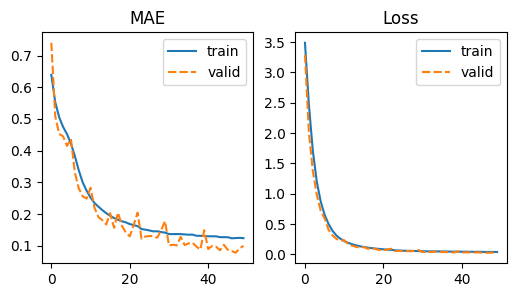

In [17]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(4)(x)

model_time_P2_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P2_L.summary()
print(model_time_P2_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P2_L.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P2_L = model_time_P2_L.fit(train_tx_L, train_ty_period_L,
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping,reduce_lr])
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P2_L.history['mae']
mae_df['valid'] = his_model_time_P2_L.history['val_mae']
loss_df['train'] = his_model_time_P2_L.history['loss']
loss_df['valid'] = his_model_time_P2_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P2_L.evaluate(test_tx_L,  test_ty_period_L, verbose=2)
pred_y_P2_L = model_time_P2_L.predict(test_tx_L)
pred_P2_L = period_to_clk(pred_y_P2_L)
np.mean(common_sense_err2(test_ty_L,pred_P2_L),axis = 0)

##### Multi Head scaled

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 148, 148,  │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 148, 148,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 34, 34,    │      9,248 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]   

 Total params: 887,373 (3.39 MB)

 Trainable params: 886,861 (3.38 MB)

 Non-trainable params: 512 (2.00 KB)

<Functional name=functional, built=True>
Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - hr_y_accuracy: 0.0896 - hr_y_loss: 2.5999 - loss: 9.2383 - min_y_loss: 0.3277 - min_y_mae: 0.4131 - val_hr_y_accuracy: 0.1012 - val_hr_y_loss: 2.6594 - val_loss: 8.3216 - val_min_y_loss: 0.6039 - val_min_y_mae: 0.6938 - learning_rate: 1.0000e-04
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - hr_y_accuracy: 0.1137 - hr_y_loss: 2.4491 - loss: 7.1839 - min_y_loss: 0.0968 - min_y_mae: 0.2560 - val_hr_y_accuracy: 0.1198 - val_hr_y_loss: 2.4066 - val_loss: 5.9647 - val_min_y_loss: 0.0817 - val_min_y_mae: 0.2311 - learning_rate: 1.0000e-04
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - hr_y_accuracy: 0.1446 - hr_y_loss: 2.3487 - loss: 5.6003 - min_y_loss: 0.0838 - min_y_mae: 0.2353 - val_hr_y_accuracy: 0.1864 - val_hr_y_loss: 2.2187 - val_loss: 4.6589 - val_min_y_loss: 0.0710 - val_min_y_mae: 0.2115 - learning_rate: 1.0000e-04
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step

array([0.02611111, 5.86833333])

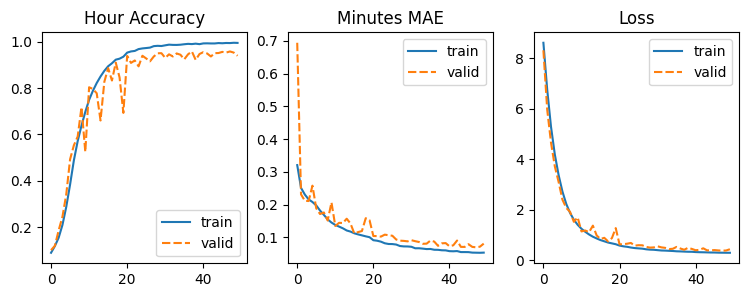

In [18]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(1,name='min_y')(min_y)

model_time_MH1_L = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH1_L.summary()
print(model_time_MH1_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH1_L.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH1_L = model_time_MH1_L.fit(train_tx_L, {'hr_y': train_ty_L[:,0], 'min_y': train_ty_L[:,1]/59},
                                    epochs = 50, validation_split=0.1, batch_size = 32,
                                    callbacks = [early_stopping, reduce_lr])
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH1_L.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH1_L.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH1_L.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH1_L.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH1_L.history['loss']
loss_df['valid'] = his_model_time_MH1_L.history['val_loss']
fig, axs = plt.subplots(ncols=3,figsize=(9,3))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
model_time_MH1_L.evaluate(test_tx_L,  {'hr_y': test_ty_L[:, 0], 'min_y': test_ty_L[:, 1] / 59}, verbose=2)
pred_hr_MH1_L,pred_min_MH1_L = model_time_MH1_L.predict(test_tx_L)
hr_MH1_L = np.argmax(tf.nn.softmax(pred_hr_MH1_L),axis=1)
min_MH1_L = np.round(pred_min_MH1_L*60).flatten()
hr_MH1_L[:10],min_MH1_L[:10]
pred_MH1_L = np.array([hr_MH1_L,min_MH1_L]).T
np.mean(common_sense_err2(test_ty_L,pred_MH1_L),axis = 0)